In [1]:
%matplotlib notebook
import os

import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.neighbors import NearestNeighbors
from IPython.display import display
from PIL import Image
import matplotlib.pyplot as plt
import sys
sys.path.insert(0, '../vae/')
from VAE import VAE
from tqdm import tnrange, tqdm_notebook

image_dim = 32

# Clustered classes and their inverse mappings

In [2]:
clustered_classes = []
mapping_classes_index = dict()
clustered_classes_count = []
file_name = 'class_clusters.txt'
with open(file_name, 'rt') as file:
    lines = file.read().splitlines()
    idx = -1
    for line in lines:
        words = line.split('\t')
        if not line.startswith('\t'):
            clustered_classes.append(set())
            clustered_classes_count.append(0)
            idx += 1
        class_name = line.strip().split('\t')[0]
        mapping_classes_index[class_name] = idx
        clustered_classes_count[idx] += int(line.strip().split('\t')[-1])
        clustered_classes[idx].add(class_name)

In [3]:
from pprint import pprint
class_with_count = list(zip(clustered_classes, clustered_classes_count))
class_with_count.sort(key=lambda x: x[1], reverse=True)

In [4]:
from math import ceil
filtered_classes = [x[0] for i,x in enumerate(class_with_count) if x[1]>500]
filtered_classes_count = [x[1] for i,x in enumerate(class_with_count) if x[1]>500]
mapping_filtered_classes = dict()
for i,classes in enumerate(filtered_classes):
    for c in classes:
        mapping_filtered_classes[c] = i

clustered_classes = filtered_classes
clustered_classes_count = filtered_classes_count

mapping_classes_index = mapping_filtered_classes

NUM_CLASSES = len(clustered_classes)
NUM_BYTES_FOR_MASK = NUM_CLASSES+1
print(NUM_CLASSES, NUM_BYTES_FOR_MASK)

24 25


In [5]:
print('\n'.join([', '.join(x)+': '+str(y) for x,y in zip(clustered_classes, clustered_classes_count)]))

Woman, Human body, Person, Man, Boy, Girl: 44429
Nose, Mouth, Hand, Ear, Hair, Head, Beard, Arm, Face, Leg, Eye: 24164
Clothing, Brassiere, Shirt, Jacket, Shorts, Skirt, Tie, Dress, Trousers, Jeans, Suit, Coat: 18591
Land vehicle, Car, Bus, Train, Truck, Bicycle wheel, Van, Motorcycle, Auto part, Vehicle, Licence plate, Tank, Wheel, Taxi, Tire, Bike: 13831
Drink, Tin can, Beer, Bottle, Juice, Cocktail, Wine glass, Wine, Coffee: 8164
Food, Strawberry, Sandwich, Fast food, Vegetable, Mushroom, Salad, Tomato, Squash, Fruit, Dessert, Cake, Bread, Seafood, Snack, Muffin, Baked goods, Pizza, Pastry, Ice cream, Dairy, Pumpkin: 4988
High heels, Sandal, Boot, Footwear: 4774
Mammal, Deer, Monkey, Carnivore, Squirrel, Tortoise, Bear, Cattle, Reptile, Lizard, Sheep, Turtle, Animal, Elephant, Lion, Cat, Horse, Frog, Dog: 3137
Laptop, Television, Computer monitor, Computer keyboard, Camera, Mobile phone: 3056
Sofa bed, Chair, Kitchen & dining room table, Table, Kitchen appliance, Couch, Vase, Chest 

# Retreive images from dataset

In [6]:
class ImageManager:
    def __init__(self, folder_path, td_output_dir, od_output_dir, npy_data_dir, start, end, overwrite=False):
        self.start = start
        self.end = end
        self.folder_path = folder_path
        self.overwrite = overwrite
        self.od_output_dir = od_output_dir
        self.td_output_dir = td_output_dir
        self.npy_data_dir = npy_data_dir
        self.index = 0
        self.files = self.resized_images()
        self.totalFiles = len(self.files)

    def next_batch(self, batch_size):
        start = self.index
        self.index += batch_size
        if self.index > self.totalFiles:
            self.index = 0
            file_order = np.arange(self.totalFiles)
            np.random.shuffle(file_order)
            self.files = self.files[file_order]
            start = 0
            self.index = batch_size
        return self.files[start : self.index]

    def get_images_and_masks(self, i):
#         print('Reading:', i)
        path = os.path.join(self.folder_path, str(i))
        file_names = os.listdir(path)
        masks = np.zeros((len(file_names), image_dim, image_dim, NUM_BYTES_FOR_MASK), np.uint8)
        delete_mask = []
        for idx, file_name in enumerate(tqdm_notebook(file_names,desc='Read:'+str(i))):
            name = os.path.basename(file_name).split('.')[0]
            td_output_file = os.path.join(self.td_output_dir, str(i), name)+'.txt'
            od_output_file = os.path.join(self.od_output_dir, str(i), name)+'.txt'
            if file_name.endswith('.jpg') and (os.path.isfile(td_output_file) 
                                               or os.path.isfile(od_output_file)):
#                 orig_img = cv2.imread(os.path.join(path, file_name))
#                 masks[idx, :, :, :3] = cv2.resize(orig_img, (100, 100))
                orig_img = Image.open(os.path.join(path, file_name))
#                 print(orig_img.size)
                
                if os.path.isfile(td_output_file):
                    with open(td_output_file, 'rt') as file:
                        lines = file.read().splitlines()
                        for line in lines:
                            coord = [int(x) for x in line.split(',')]
                            img_width, img_height = masks[idx].shape[0],masks[idx].shape[1]
                            l = round(coord[0]*img_width/orig_img.size[0])
                            r = round(coord[2]*img_width/orig_img.size[0])
                            t = round(coord[1]*img_height/orig_img.size[1])
                            b = round(coord[-1]*img_height/orig_img.size[1])
#                             l = round(coord[0]*img_width/orig_img.shape[1])
#                             r = round(coord[2]*img_width/orig_img.shape[1])
#                             t = round(coord[1]*img_height/orig_img.shape[0])
#                             b = round(coord[-1]*img_height/orig_img.shape[0])
                            masks[idx,t:b,l:r,0] = 1
                            
                if os.path.isfile(od_output_file):       
                    with open(od_output_file, 'rt') as file:
                        lines = file.read().splitlines()
                        for line in lines:
                            try:
                                class_idx = mapping_classes_index[
                                    line.split(':')[0].split(',')[-1]]+1
#                                 print(class_idx, line.split(':')[0].split(',')[-1])
                                coord = line.split(':')[1].split(',')
                                coord = [round(float(x)*masks[idx].shape[(j+1)%2]) for j,x in enumerate(coord)]
#                                 masks[idx,coord[0]:coord[2],coord[1]:coord[3],
#                                       (class_idx//8)-1] += 1<<(class_idx%8)
                                masks[idx,coord[0]:coord[2],coord[1]:coord[3],
                                      class_idx] = 1
                            except KeyError:
#                                 print('Keyerror',line.split(':')[0].split(',')[-1])
                                pass
            else:
                delete_mask.append(idx)
                
        np.delete(masks, delete_mask)
        if not os.path.exists(self.npy_data_dir):
            os.makedirs(self.npy_data_dir)
        np.save(os.path.join(self.npy_data_dir, str(i)), masks)
#         print('Saved:',os.path.join(self.npy_data_dir, str(i)),'\nNumber of files',masks.shape[0])
        return masks
        
    def resized_images(self):
        final_masks = None
        for i in tqdm_notebook(range(self.start, self.end), desc='1st loop'):
            if not os.path.isfile(os.path.join(self.npy_data_dir, str(i))+'.npy') or self.overwrite:
                masks = self.get_images_and_masks(i)
            else:
                masks = np.load(os.path.join(self.npy_data_dir, str(i))+'.npy')
#                 print('Loaded:',os.path.join(self.npy_data_dir, str(i))+'.npy','\nNumber of files',masks.shape)
#             masks = masks.reshape(masks.shape[0], -1).astype(np.float16)
            if final_masks is None:
                final_masks = masks
            else:
                final_masks = np.append(final_masks,masks,axis=0)
        return final_masks

In [7]:
%%time
IMAGES_PATH = '/gpfs/scratch/asamanta/dataset/train_images/'
TEXT_DET_OUTPUT = '../../../td-output/'
OBJECT_DET_OUTPUT = '../../../od-output/'
NUMPY_DATA = '/gpfs/scratch/asamanta/dataset/numpy-data-with-mask-per-layers-size_'+str(image_dim)+'/'
OUT_TF_DATA = '/gpfs/scratch/asamanta/'

image_manager = ImageManager(IMAGES_PATH, TEXT_DET_OUTPUT, OBJECT_DET_OUTPUT, NUMPY_DATA, 0, 9)
test_image_manager = ImageManager(IMAGES_PATH, TEXT_DET_OUTPUT, OBJECT_DET_OUTPUT, NUMPY_DATA, 9, 11)

A Jupyter Widget

A Jupyter Widget


CPU times: user 1.14 s, sys: 1.86 s, total: 3 s
Wall time: 3.28 s


# Visualize one image and its masks

<IPython.core.display.Javascript object>


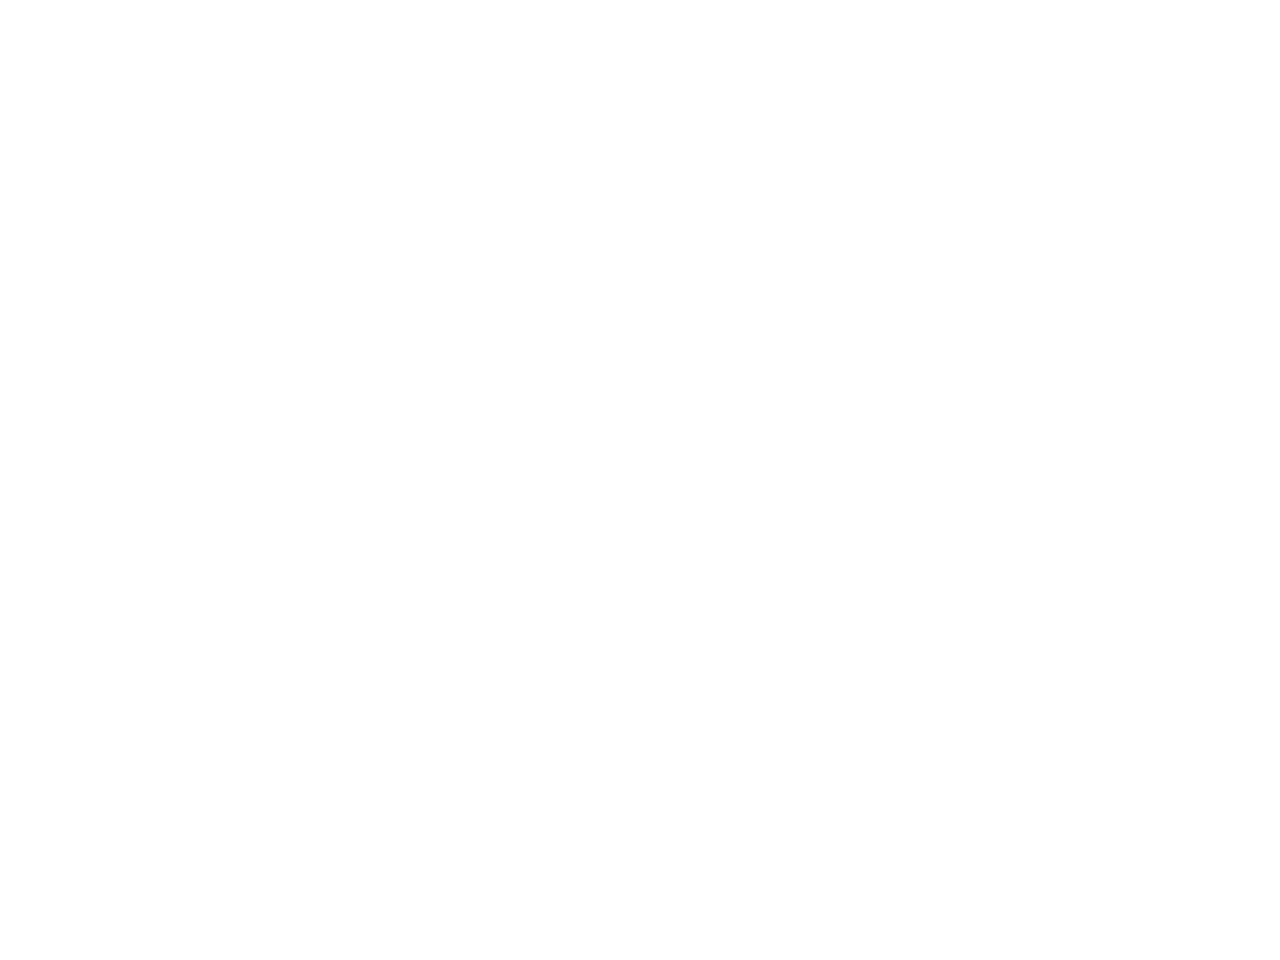

<IPython.core.display.Javascript object>


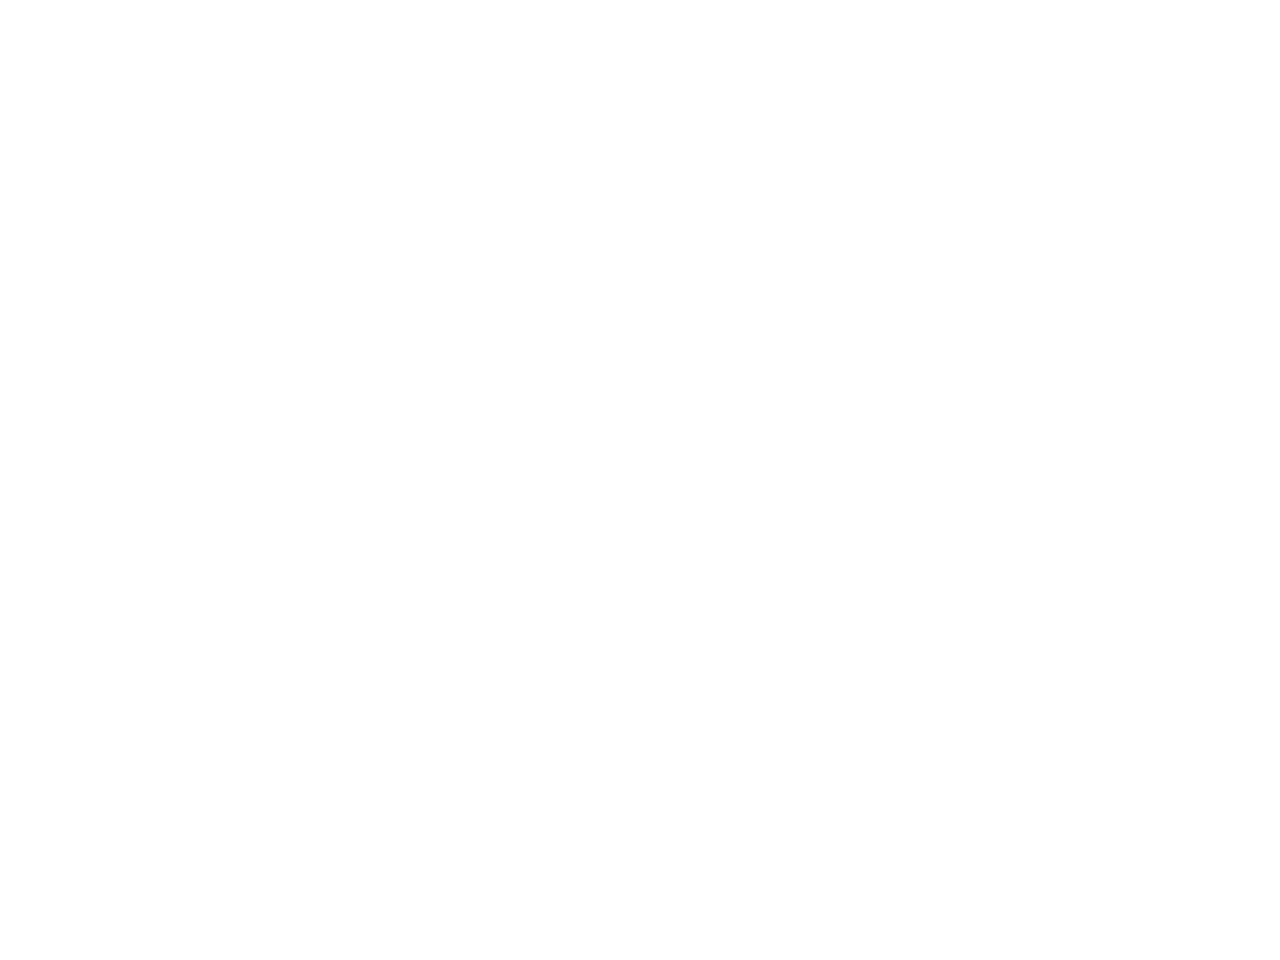

Layer: Text
Layer: {'Woman', 'Human body', 'Person', 'Man', 'Boy', 'Girl'}


<IPython.core.display.Javascript object>


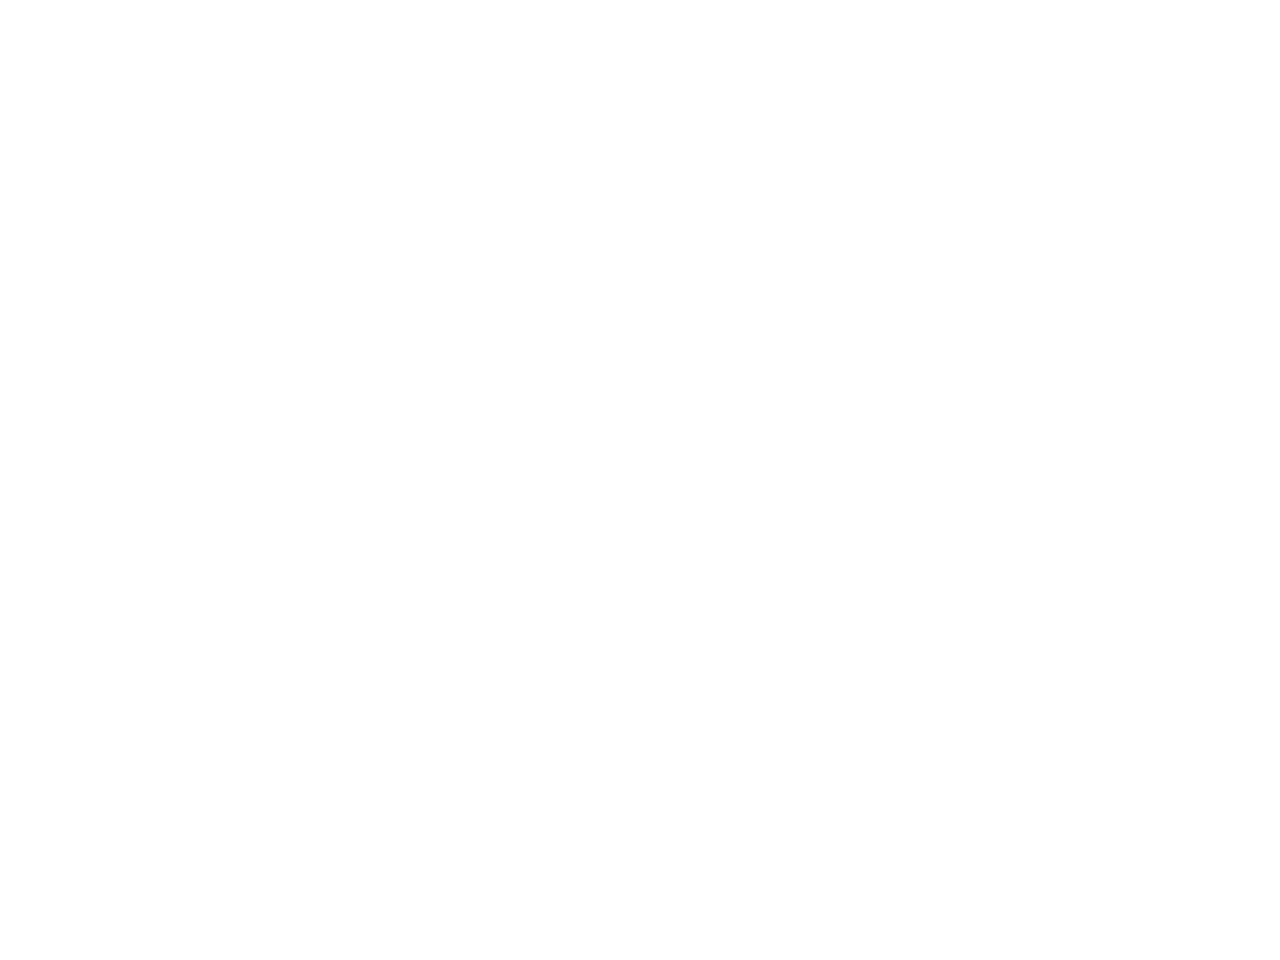

Layer: {'Nose', 'Mouth', 'Hand', 'Ear', 'Hair', 'Head', 'Beard', 'Arm', 'Face', 'Leg', 'Eye'}


<IPython.core.display.Javascript object>


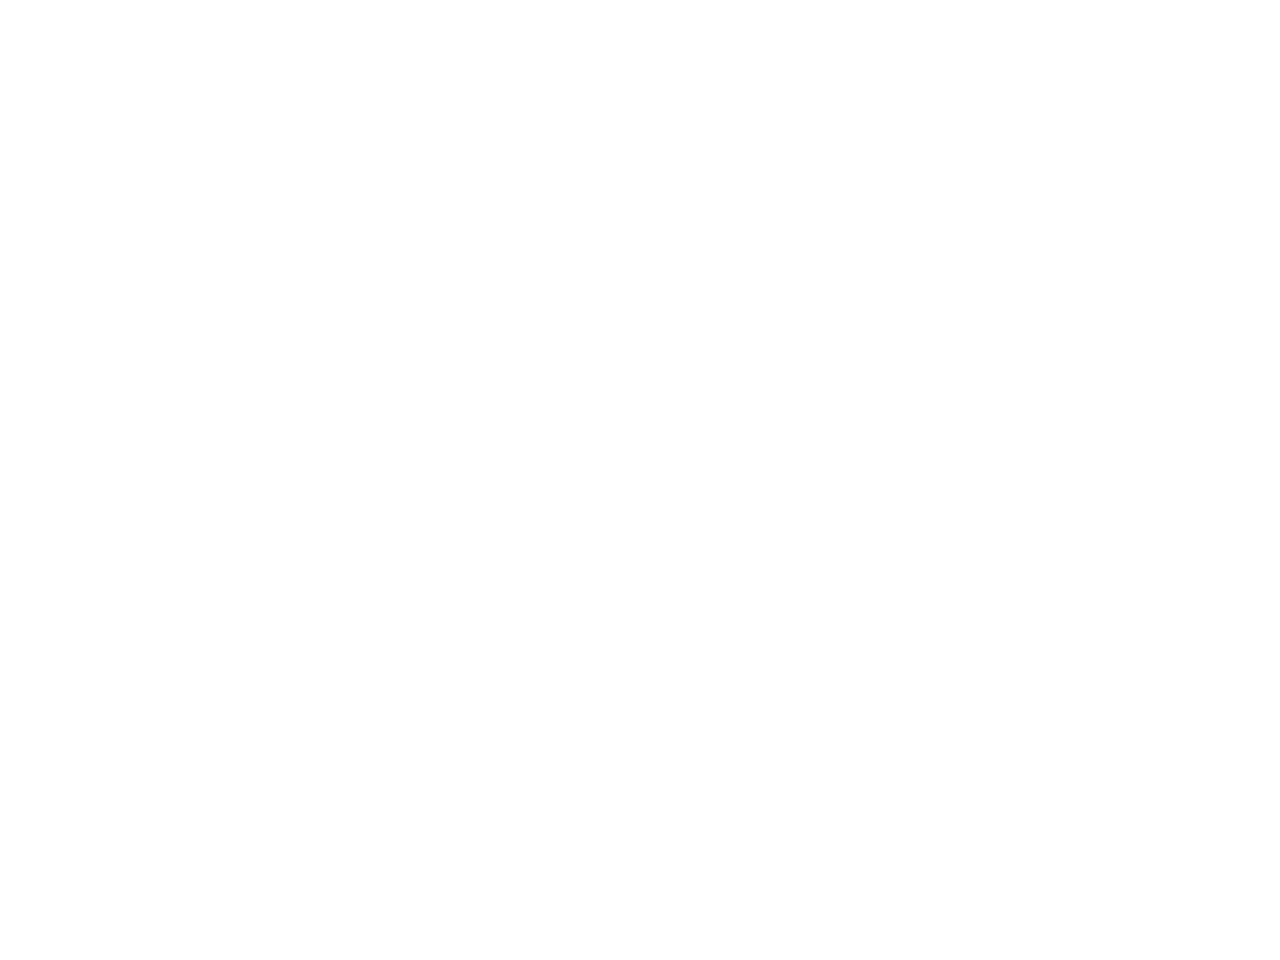

In [8]:
img_mask = image_manager.files[5].reshape([image_dim, image_dim, NUM_BYTES_FOR_MASK])
folder_path = os.path.join(image_manager.folder_path, '0')
img = cv2.imread(os.path.join(folder_path, os.listdir(folder_path)[5]))
img = cv2.resize(img, (image_dim,image_dim))

plt.figure()
plt.imshow(img)
plt.show()

plt.figure()
print('Layer: Text')
plt.imshow(img_mask[:,:,0], origin="upper", cmap="gray")
plt.show()
        
for i in range(1,NUM_BYTES_FOR_MASK):
    if np.count_nonzero(img_mask[:,:,i])>0:
        print('Layer:',clustered_classes[i-1])
        fig = plt.figure()
        plt.imshow(img_mask[:,:,i], origin="upper", cmap="gray")
        plt.show()

New MODEL

In [9]:
def xavier_init(fan_in, fan_out, constant=1): 
    """ Xavier initialization of network weights"""
    # https://stackoverflow.com/questions/33640581/how-to-do-xavier-initialization-on-tensorflow
    low = -constant*np.sqrt(6.0/(fan_in + fan_out)) 
    high = constant*np.sqrt(6.0/(fan_in + fan_out))
    return tf.random_uniform((fan_in, fan_out), 
                             minval=low, maxval=high, 
                             dtype=tf.float32)

In [10]:
class VariationalAutoencoder(object):
    """ Variation Autoencoder (VAE) with an sklearn-like interface implemented using TensorFlow.
    
    This implementation uses probabilistic encoders and decoders using Gaussian 
    distributions and  realized by multi-layer perceptrons. The VAE can be learned
    end-to-end.
    
    See "Auto-Encoding Variational Bayes" by Kingma and Welling for more details.
    """
    def __init__(self, network_architecture, transfer_fct=tf.nn.softplus, 
                 learning_rate=0.001, batch_size=100):
        self.network_architecture = network_architecture
        self.transfer_fct = transfer_fct
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        
        # tf Graph input
        self.x = tf.placeholder(tf.float32, [None, network_architecture["n_input"]])
        
        # Create autoencoder network
        self._create_network()
        # Define loss function based variational upper-bound and 
        # corresponding optimizer
        self._create_loss_optimizer()
        
        # Initializing the tensor flow variables
        init = tf.global_variables_initializer()

        # Launch the session
        self.sess = tf.InteractiveSession()
        self.sess.run(init)
    
    def _create_network(self):
        # Initialize autoencode network weights and biases
        network_weights = self._initialize_weights(**self.network_architecture)

        # Use recognition network to determine mean and 
        # (log) variance of Gaussian distribution in latent
        # space
        self.z_mean, self.z_log_sigma_sq = \
            self._recognition_network(network_weights["weights_recog"], 
                                      network_weights["biases_recog"])

        # Draw one sample z from Gaussian distribution
        n_z = self.network_architecture["n_z"]
        eps = tf.random_normal((self.batch_size, n_z), 0, 1, 
                               dtype=tf.float32)
        # z = mu + sigma*epsilon
        self.z = tf.add(self.z_mean, 
                        tf.multiply(tf.sqrt(tf.exp(self.z_log_sigma_sq)), eps))

        # Use generator to determine mean of
        # Bernoulli distribution of reconstructed input
        self.x_reconstr_mean = \
            self._generator_network(network_weights["weights_gener"],
                                    network_weights["biases_gener"])
            
    def _initialize_weights(self, n_hidden_recog_1, n_hidden_recog_2, 
                            n_hidden_gener_1,  n_hidden_gener_2, 
                            n_input, n_z):
        all_weights = dict()
        all_weights['weights_recog'] = {
            'h1': tf.Variable(xavier_init(n_input, n_hidden_recog_1)),
            'h2': tf.Variable(xavier_init(n_hidden_recog_1, n_hidden_recog_2)),
            'out_mean': tf.Variable(xavier_init(n_hidden_recog_2, n_z)),
            'out_log_sigma': tf.Variable(xavier_init(n_hidden_recog_2, n_z))}
        all_weights['biases_recog'] = {
            'b1': tf.Variable(tf.zeros([n_hidden_recog_1], dtype=tf.float32)),
            'b2': tf.Variable(tf.zeros([n_hidden_recog_2], dtype=tf.float32)),
            'out_mean': tf.Variable(tf.zeros([n_z], dtype=tf.float32)),
            'out_log_sigma': tf.Variable(tf.zeros([n_z], dtype=tf.float32))}
        all_weights['weights_gener'] = {
            'h1': tf.Variable(xavier_init(n_z, n_hidden_gener_1)),
            'h2': tf.Variable(xavier_init(n_hidden_gener_1, n_hidden_gener_2)),
            'out_mean': tf.Variable(xavier_init(n_hidden_gener_2, n_input)),
            'out_log_sigma': tf.Variable(xavier_init(n_hidden_gener_2, n_input))}
        all_weights['biases_gener'] = {
            'b1': tf.Variable(tf.zeros([n_hidden_gener_1], dtype=tf.float32)),
            'b2': tf.Variable(tf.zeros([n_hidden_gener_2], dtype=tf.float32)),
            'out_mean': tf.Variable(tf.zeros([n_input], dtype=tf.float32)),
            'out_log_sigma': tf.Variable(tf.zeros([n_input], dtype=tf.float32))}
        return all_weights
            
    def _recognition_network(self, weights, biases):
        # Generate probabilistic encoder (recognition network), which
        # maps inputs onto a normal distribution in latent space.
        # The transformation is parametrized and can be learned.
        layer_1 = self.transfer_fct(tf.add(tf.matmul(self.x, weights['h1']), 
                                           biases['b1'])) 
        layer_2 = self.transfer_fct(tf.add(tf.matmul(layer_1, weights['h2']), 
                                           biases['b2'])) 
        z_mean = tf.add(tf.matmul(layer_2, weights['out_mean']),
                        biases['out_mean'])
        z_log_sigma_sq = \
            tf.add(tf.matmul(layer_2, weights['out_log_sigma']), 
                   biases['out_log_sigma'])
        return (z_mean, z_log_sigma_sq)

    def _generator_network(self, weights, biases):
        # Generate probabilistic decoder (decoder network), which
        # maps points in latent space onto a Bernoulli distribution in data space.
        # The transformation is parametrized and can be learned.
        layer_1 = self.transfer_fct(tf.add(tf.matmul(self.z, weights['h1']), 
                                           biases['b1'])) 
        layer_2 = self.transfer_fct(tf.add(tf.matmul(layer_1, weights['h2']), 
                                           biases['b2'])) 
        x_reconstr_mean = \
            tf.nn.sigmoid(tf.add(tf.matmul(layer_2, weights['out_mean']), 
                                 biases['out_mean']))
        return x_reconstr_mean
            
    def _create_loss_optimizer(self):
        # The loss is composed of two terms:
        # 1.) The reconstruction loss (the negative log probability
        #     of the input under the reconstructed Bernoulli distribution 
        #     induced by the decoder in the data space).
        #     This can be interpreted as the number of "nats" required
        #     for reconstructing the input when the activation in latent
        #     is given.
        # Adding 1e-10 to avoid evaluation of log(0.0)
        
        self.x_reconstr_mean = tf.clip_by_value(self.x_reconstr_mean, 1e-10, 1-(1e-10))
        reconstr_loss = \
            -tf.reduce_sum(self.x * tf.log(1e-10 + self.x_reconstr_mean)
                           + (1-self.x) * tf.log(1e-10 + 1 - self.x_reconstr_mean),
                           1)
        # 2.) The latent loss, which is defined as the Kullback Leibler divergence 
        ##    between the distribution in latent space induced by the encoder on 
        #     the data and some prior. This acts as a kind of regularizer.
        #     This can be interpreted as the number of "nats" required
        #     for transmitting the the latent space distribution given
        #     the prior.
        latent_loss = -0.5 * tf.reduce_sum(1 + self.z_log_sigma_sq 
                                           - tf.square(self.z_mean) 
                                           - tf.exp(self.z_log_sigma_sq), 1)
        self.cost = tf.reduce_mean(latent_loss+reconstr_loss)   # average over batch
        # Use ADAM optimizer
        self.optimizer = \
            tf.train.AdamOptimizer(learning_rate=self.learning_rate).minimize(self.cost)
        
    def partial_fit(self, X):
        """Train model based on mini-batch of input data.
        
        Return cost of mini-batch.
        """
        opt, cost = self.sess.run((self.optimizer, self.cost), 
                                  feed_dict={self.x: X})
        return cost
    
    def transform(self, X):
        """Transform data by mapping it into the latent space."""
        # Note: This maps to mean of distribution, we could alternatively
        # sample from Gaussian distribution
        return self.sess.run(self.z_mean, feed_dict={self.x: X})
    
    def generate(self, z_mu=None):
        """ Generate data by sampling from latent space.
        
        If z_mu is not None, data for this point in latent space is
        generated. Otherwise, z_mu is drawn from prior in latent 
        space.        
        """
        if z_mu is None:
            z_mu = np.random.normal(size=self.network_architecture["n_z"])
        # Note: This maps to mean of distribution, we could alternatively
        # sample from Gaussian distribution
        return self.sess.run(self.x_reconstr_mean, 
                             feed_dict={self.z: z_mu})
    
    def reconstruct(self, X):
        """ Use VAE to reconstruct given data. """
        return self.sess.run(self.x_reconstr_mean, 
                             feed_dict={self.x: X})

In [11]:
tf.reset_default_graph()

learning_rate = 1e-5
num_steps = 10
batch_size = 25
# Network Parameters
NUM_BYTES_FOR_MASK = 5+1
input_image_dim = image_dim*image_dim*NUM_BYTES_FOR_MASK # images are 100x100 pixels
hidden_dim1 = 2048
hidden_dim2 = 512
latent_dim = 64
n_samples = image_manager.files.shape[0]
beta = 4

network_architecture = \
    dict(n_hidden_recog_1=hidden_dim1, # 1st layer encoder neurons
         n_hidden_recog_2=hidden_dim2, # 2nd layer encoder neurons
         n_hidden_gener_1=hidden_dim2, # 1st layer decoder neurons
         n_hidden_gener_2=hidden_dim1, # 2nd layer decoder neurons
         n_input=input_image_dim, # MNIST data input (img shape: 28*28)
         n_z=latent_dim)  # dimensionality of latent space

vae = VariationalAutoencoder(network_architecture, 
                                 learning_rate=learning_rate, 
                                 batch_size=batch_size, transfer_fct=tf.nn.relu)

In [20]:
def train(vae, batch_size, training_epochs=10, display_step=2):
    
    fig,ax = plt.subplots(1,5)

    fig.show()
#     fig.canvas.draw()
    
    test_image = image_manager.next_batch(batch_size)
    test_image = test_image[:, :, :, :NUM_BYTES_FOR_MASK]
    temp_img = test_image[0][:,:,0]
    ax[2].imshow(temp_img, cmap='gray')
    test_image = test_image.reshape(test_image.shape[0], -1).astype(np.float16)
    
    fig.canvas.draw()
    cost_list = []
    # Training cycle
    try:
        for epoch in tqdm_notebook(range(training_epochs)):
            avg_cost = 0.
            total_batch = int(n_samples / batch_size)
            # Loop over all batches
            for i in range(total_batch):

                batch_x = image_manager.next_batch(batch_size)
                batch_x = batch_x[:, :, :, :NUM_BYTES_FOR_MASK]
                sample_image = batch_x[0,:,:,0]
                batch_x = batch_x.reshape(batch_x.shape[0], -1).astype(np.float16)

                # Fit training using batch data
                cost = vae.partial_fit(batch_x)
                cost_list.append(cost)
                # Compute average loss
                avg_cost += cost / n_samples * batch_size
                if i%(total_batch//10) == 0:
                    ax[0].clear()
                    ax[0].plot(cost_list[-total_batch:])
                    x_reconstr = vae.reconstruct(test_image)
                    x_reconstr = x_reconstr.reshape(-1, image_dim,image_dim, NUM_BYTES_FOR_MASK)[0,:,:,0]
                    
                    ax[1].clear()
                    ax[1].imshow(x_reconstr, cmap='gray')
                    
                    ax[3].clear()
                    ax[3].imshow(sample_image, cmap='gray')
                    
                    x_reconstr = vae.reconstruct(batch_x)
                    x_reconstr = x_reconstr.reshape(-1, image_dim,image_dim, NUM_BYTES_FOR_MASK)[0,:,:,0]
                    ax[4].clear()
                    ax[4].imshow(x_reconstr, cmap='gray')
                    
                try:
                    fig.canvas.draw()
                except AttributeError:
                    print('NAN loss')
                    break
            # Display logs per epoch step
            if epoch % display_step == 0:
                print("Epoch:", '%04d' % (epoch+1), 
                      "cost=", "{:.9f}".format(avg_cost))
    except KeyboardInterrupt:
        pass
    return vae

<IPython.core.display.Javascript object>


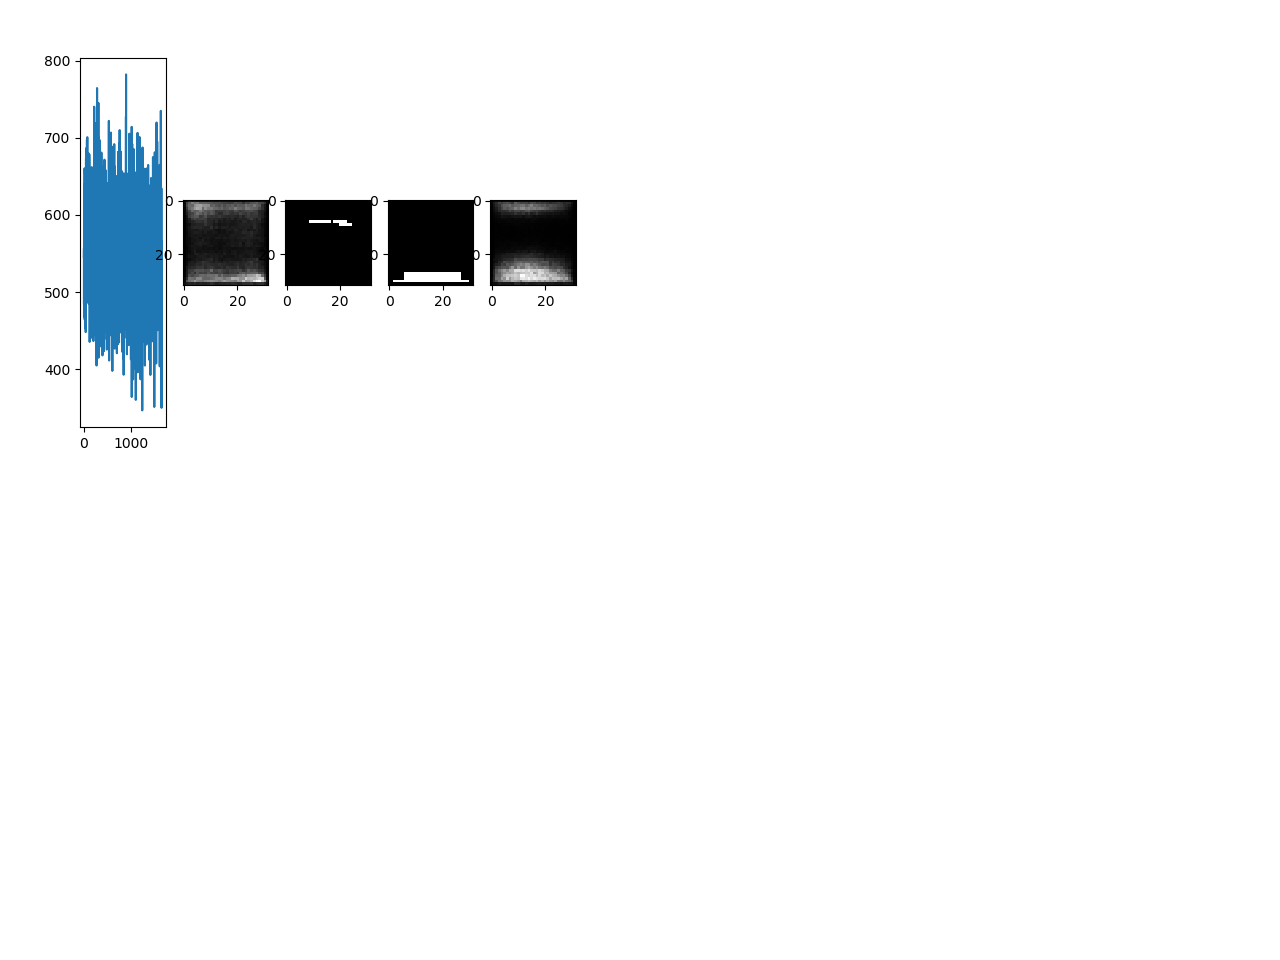

A Jupyter Widget


Epoch: 0001 cost= 873.901905688
Epoch: 0003 cost= 639.816566941
Epoch: 0005 cost= 568.202245740


In [ ]:
%matplotlib notebook
train(vae, training_epochs=50, batch_size=batch_size)
# plt.show()

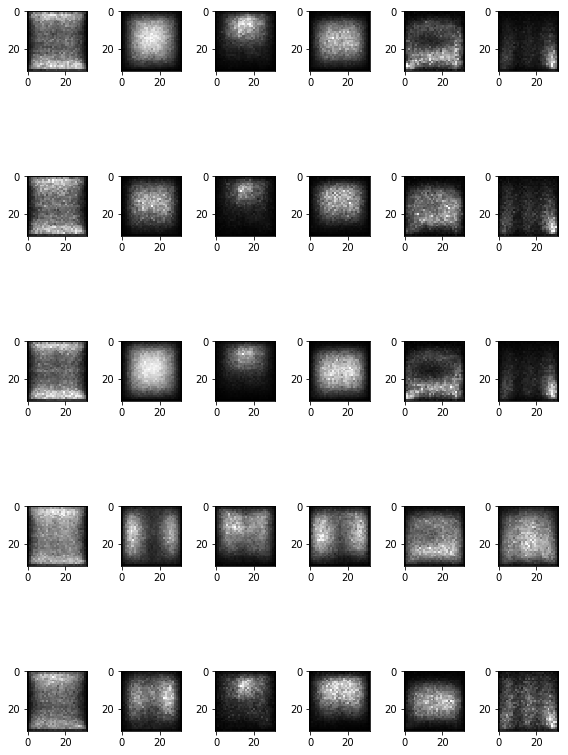

In [73]:
%matplotlib inline
z_mu = np.random.normal(size=(batch_size,latent_dim))
x_reconstruct = vae.generate(z_mu=z_mu)
x_reconstruct = x_reconstruct.reshape(-1, image_dim,image_dim, NUM_BYTES_FOR_MASK)
# x_reconstruct[math.n] = 1
plt.figure(figsize=(8, 12))
index = 1
for i in range(5):
    for j in range(NUM_BYTES_FOR_MASK):
        plt.subplot(5, NUM_BYTES_FOR_MASK, index)
        index+=1
        try:
            plt.imshow(x_reconstruct[i,:,:,j],cmap="gray")
        except AttributeError:
            pass
#         plt.title("Reconstruction")
#     plt.show()
plt.tight_layout()
plt.show()

In [33]:
%matplotlib inline
x_sample = test_image_manager.next_batch(16)[:,:,:,:1]
x_sample = x_sample.reshape(x_sample.shape[0],-1)
x_reconstruct = vae.reconstruct(x_sample)
plt.figure(figsize=(8, 12))
for i in range(5):
    plt.subplot(5, 2, 2*i + 1)
    plt.imshow(x_sample[i].reshape(100, 100), cmap="gray")
    plt.title("Test input")
    plt.colorbar()
    plt.subplot(5, 2, 2*i + 2)
    plt.imshow(x_reconstruct[i].reshape(100, 100),cmap="gray")
    plt.title("Reconstruction")
    plt.colorbar()
#     plt.show()
plt.tight_layout()
plt.show()


ValueError: Cannot feed value of shape (16, 1024) for Tensor 'Placeholder:0', which has shape '(?, 6144)'

OLD MODEL

# BETA VARIATIONAL AUTOENCODER

In [9]:
# Parameters

tf.reset_default_graph()

learning_rate = 1e-6
num_steps = 50
batch_size = 16
# Network Parameters
NUM_BYTES_FOR_MASK = 0+1
image_dim = 100*100*NUM_BYTES_FOR_MASK # images are 100x100 pixels
hidden_dim1 = 2048
hidden_dim2 = 256
latent_dim = 64
n_samples = image_manager.files.shape[0]
beta = 4
# A custom initialization (see Xavier Glorot init)
def glorot_init(shape):
    return tf.random_normal(shape=shape, stddev=1. / tf.sqrt(shape[0] / 2.))

### Path where model is saved

In [9]:
MODEL_PATH = os.path.join(OUT_TF_DATA,'models')+'/'+'_'.join(['vae',str(hidden_dim1),str(hidden_dim2),str(latent_dim),'sigmoid','adam'])
print(MODEL_PATH)

NameError: name 'hidden_dim1' is not defined

In [ ]:
# Variables
weights = {
    'encoder_h1': tf.Variable(glorot_init([image_dim, hidden_dim1])),
    'encoder_h2': tf.Variable(glorot_init([hidden_dim1, hidden_dim2])),
    'z_mean': tf.Variable(glorot_init([hidden_dim2, latent_dim])),
    'z_std': tf.Variable(glorot_init([hidden_dim2, latent_dim])),
    'decoder_h1': tf.Variable(glorot_init([latent_dim, hidden_dim2])),
    'decoder_h2': tf.Variable(glorot_init([hidden_dim2, hidden_dim1])),
    'decoder_out': tf.Variable(glorot_init([hidden_dim1, image_dim]))
}
biases = {
    'encoder_b1': tf.Variable(glorot_init([hidden_dim1])),
    'encoder_b2': tf.Variable(glorot_init([hidden_dim2])),
    'z_mean': tf.Variable(glorot_init([latent_dim])),
    'z_std': tf.Variable(glorot_init([latent_dim])),
    'decoder_b1': tf.Variable(glorot_init([hidden_dim2])),
    'decoder_b2': tf.Variable(glorot_init([hidden_dim1])),
    'decoder_out': tf.Variable(glorot_init([image_dim]))
}

In [53]:
# Building the encoder
input_image = tf.placeholder(tf.float32, shape=[None, image_dim], name='input')
encoder1 = tf.matmul(input_image, weights['encoder_h1']) + biases['encoder_b1']
encoder1 = tf.nn.relu(encoder1)
# encoder1 = tf.nn.dropout(encoder1, 0.5)
encoder2 = tf.matmul(encoder1, weights['encoder_h2']) + biases['encoder_b2']
encoder = tf.nn.relu(encoder2)
# encoder2 = tf.nn.dropout(encoder, 0.5)
z_mean = tf.matmul(encoder, weights['z_mean']) + biases['z_mean']
z_std = tf.matmul(encoder, weights['z_std']) + biases['z_std']

# Sampler: Normal (gaussian) random distribution
eps = tf.random_normal(tf.shape(z_std), dtype=tf.float32, mean=0., stddev=1.0,
                       name='epsilon')
z = z_mean + tf.exp(z_std / 2) * eps

# Building the decoder (with scope to re-use these layers later)
decoder1 = tf.matmul(z, weights['decoder_h1']) + biases['decoder_b1']
decoder1 = tf.nn.relu(decoder1)
# decoder1 = tf.nn.dropout(decoder1, 0.5)
decoder2 = tf.matmul(decoder1, weights['decoder_h2']) + biases['decoder_b2']
decoder2 = tf.nn.relu(decoder2)
# decoder2 = tf.nn.dropout(decoder2, 0.5)
decoder = tf.matmul(decoder2, weights['decoder_out']) + biases['decoder_out']
decoder = tf.nn.sigmoid(decoder, name='decoder')

In [54]:
# Define VAE Loss
def vae_loss(x_reconstructed, x_true):
    # Reconstruction loss
#     x_reconstructed = tf.clip_by_value(x_reconstructed, 1e-7, 1 - 1e-7)
    encode_decode_loss = x_true * tf.log(1e-7 + x_reconstructed) \
                         + (1 - x_true) * tf.log(1e-7 + 1 - x_reconstructed)
    
    encode_decode_loss = -tf.reduce_sum(encode_decode_loss, 1)
    # KL Divergence loss
    kl_div_loss = 1 + z_std - tf.square(z_mean) - tf.exp(z_std)
    kl_div_loss = -beta * 0.5 * tf.reduce_sum(kl_div_loss, 1)
    return tf.reduce_mean(encode_decode_loss + kl_div_loss)

loss_op = vae_loss(decoder, input_image)
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
train_op = optimizer.minimize(loss_op)


# TEST GENERATED IMAGES

In [55]:
def image_test_and_plot(image_manager, sess):
    dim_ = 100
    n = 4
    canvas_orig = np.empty((dim_ * n, dim_ * n, NUM_BYTES_FOR_MASK))
    canvas_recon = np.empty((dim_ * n, dim_ * n, NUM_BYTES_FOR_MASK))
    for i in range(n):
        # Image test set
        batch_x = image_manager.next_batch(n)
        batch_x = batch_x[:, :, :, :NUM_BYTES_FOR_MASK]
        batch_x = batch_x.reshape(batch_x.shape[0], -1).astype(np.float16)
        # Encode and decode the digit image
        output = tf.get_default_graph().get_tensor_by_name("decoder:0")
        ip_img= tf.get_default_graph().get_tensor_by_name("input:0")
        g = sess.run(output, feed_dict={ip_img: batch_x})
#         print(g)
        # Display original images
        for j in range(n):
    #         print (batch_x[j])
            # Draw the generated digits
            canvas_orig[i * dim_:(i + 1) * dim_, j * dim_:
                        (j + 1) * dim_,:] = batch_x[j].reshape([dim_, dim_, NUM_BYTES_FOR_MASK])

    #     print (np.max(g[0]))
        # Display reconstructed images
        for j in range(n):
            # Draw the generated digits
            canvas_recon[i * dim_:(i + 1) * dim_, j * dim_:
                         (j + 1) * dim_,:] = g[j].reshape([dim_, dim_, NUM_BYTES_FOR_MASK])
    print(np.linalg.norm(canvas_orig - canvas_recon)/n)

    
    print("Original Images vs Reconstructed Images")  
    for i in range(NUM_BYTES_FOR_MASK):
        print('Layer:',i)
        f, axarr = plt.subplots(1,2)
        axarr[0].imshow(canvas_orig[:,:,i], origin="upper", cmap="gray")
        axarr[1].imshow(canvas_recon[:,:,i], origin="upper", cmap="gray")
        plt.show()
    


# RUN MODEL

# SET GPU List

In [56]:
os.environ['CUDA_VISIBLE_DEVICES'] = '0,1,2,3'

<IPython.core.display.Javascript object>


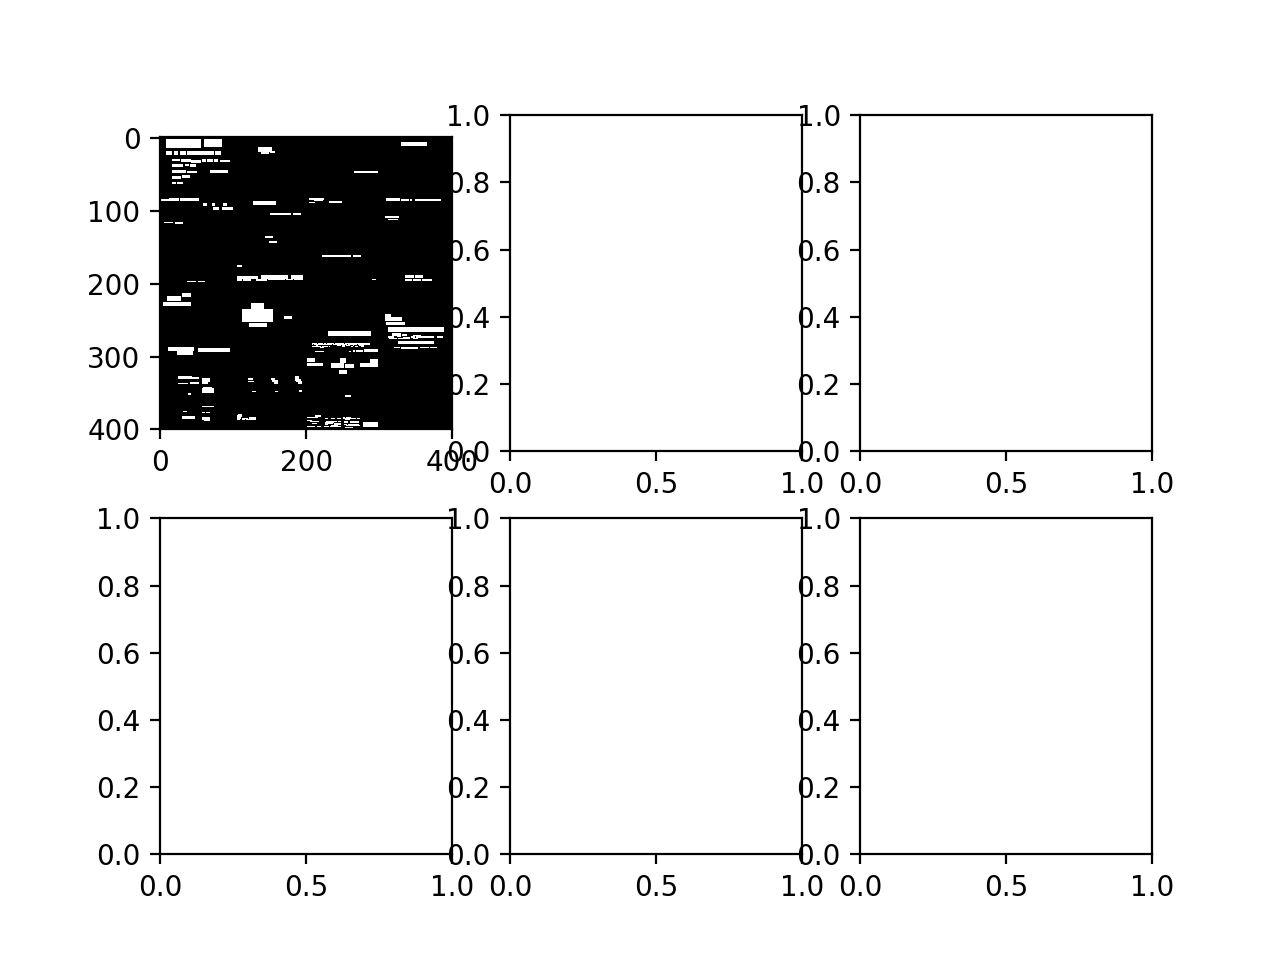

(400, 400, 1)


In [57]:
import math
test_images = test_image_manager.next_batch(16)[:, :, :, :NUM_BYTES_FOR_MASK]
test_images = test_images.reshape(test_images.shape[0], -1).astype(np.float16)
n = 4
dim_ = 100
canvas_recon = np.zeros((dim_ * n, dim_ * n, NUM_BYTES_FOR_MASK))
for j in range(n*n):
    # Draw the generated digits 
    x = j//n
    y = j%n
#         print(test_images[j].reshape([100, 100, NUM_BYTES_FOR_MASK]).shape)
#         print(test_images[j].shape)
    canvas_recon[y * 100:(y + 1) * 100, x * 100:
                 (x + 1) * 100,:] = test_images[j].reshape([100, 100, NUM_BYTES_FOR_MASK])
f, axarr = plt.subplots(2,3)
print(canvas_recon.shape)
for i in range(NUM_BYTES_FOR_MASK):
    img_disp = np.round(canvas_recon[:,:,i])
    img_disp[img_disp>0] = 1
    axarr[i//3][i%3].imshow(canvas_recon[:,:,i], origin="upper", cmap="gray")
plt.show()

<IPython.core.display.Javascript object>


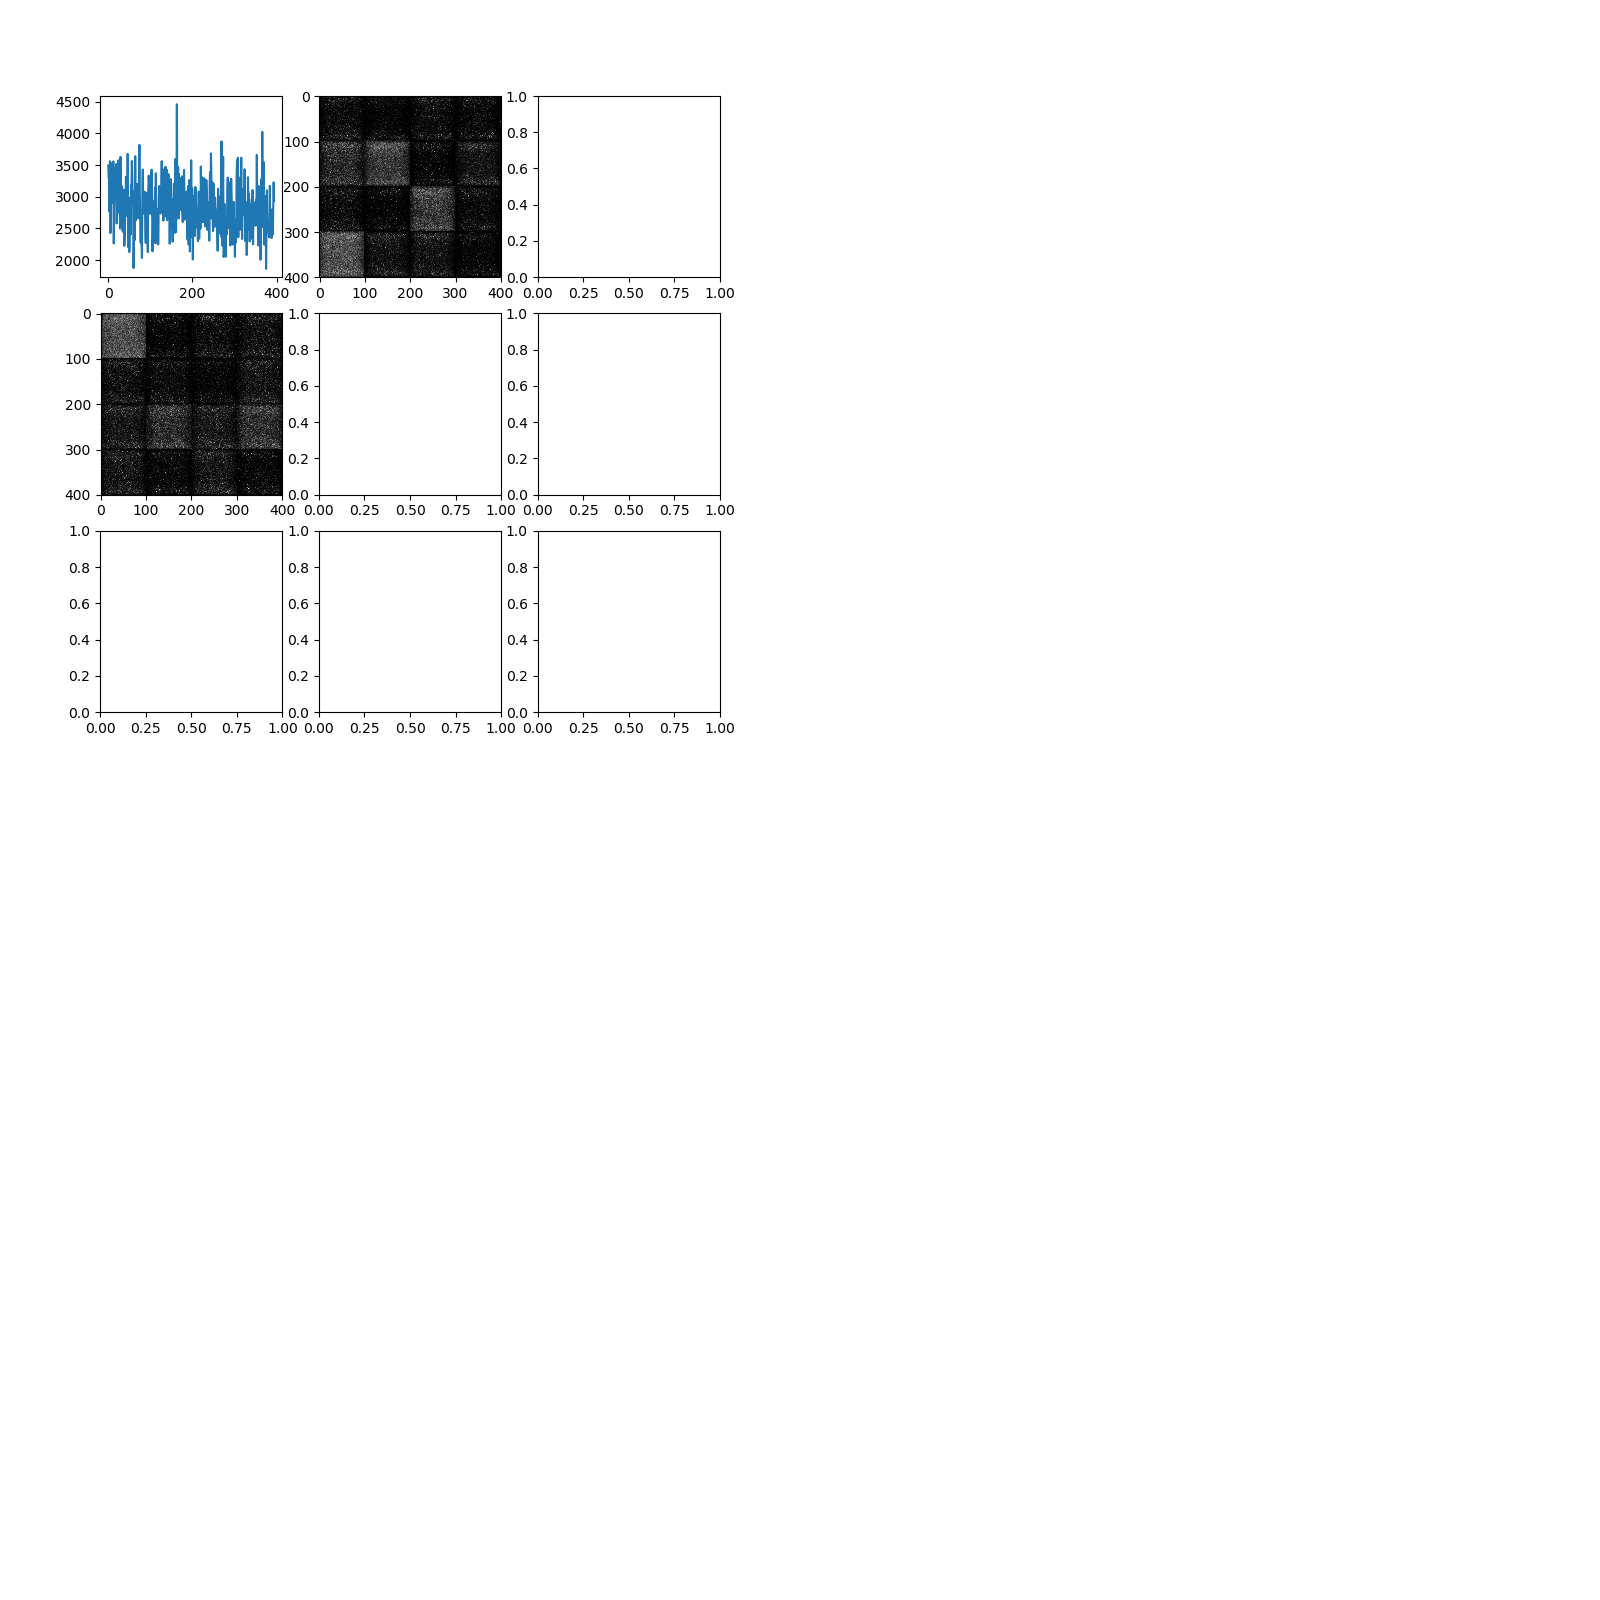

A Jupyter Widget

In [ ]:
# %%time
%matplotlib notebook
# Start Training
# Start a new TF session
# Initialize the variables (i.e. assign their default value)
init = tf.global_variables_initializer()
batch_loss_plot = []
test_loss_plot = []
with tf.Session() as sess:


    # Run the initializer
    sess.run(init)
    
    saver = tf.train.Saver()

    fig,ax = plt.subplots(3,3,figsize=(8,8))
#     plt.ion()
    
    for k in range(NUM_BYTES_FOR_MASK):
        ax[(k+3)//3][(k+3)%3].clear()
        ax[(k+3)//3][(k+3)%3].imshow(canvas_recon[:,:,k], origin="upper", cmap="gray")
    
#     fig.show()
    fig.canvas.draw()
    # Training
    for i in tqdm_notebook(range(num_steps)):
        # Prepare Data
        # Get the next batch of MNIST data (only images are needed, not labels)
        avg_loss = 0.
        total_batch = n_samples // batch_size
        total_batch = total_batch//5
        
        # Loop over all batches
        for j in range(total_batch):
            batch_x = image_manager.next_batch(batch_size)
            batch_x = batch_x[:, :, :, :NUM_BYTES_FOR_MASK]
            batch_x = batch_x.reshape(batch_x.shape[0], -1).astype(np.float16)
            # Train
            feed_dict = {input_image: batch_x}
            _, l = sess.run([train_op, loss_op], feed_dict=feed_dict)
            avg_loss += l / n_samples * batch_size
            batch_loss_plot.append(l)
            ax[0][0].clear()
            ax[0][0].plot(batch_loss_plot[-total_batch:])
            if (j%(total_batch//5))==0:
                g = decoder.eval(feed_dict={input_image: batch_x})
                for k in range(16):
                    # Draw the generated digits 
                    x = k//4
                    y = k%4
                    canvas_recon[y * 100:(y + 1) * 100, x * 100:
                                 (x + 1) * 100,:] = g[k].reshape([100, 100, NUM_BYTES_FOR_MASK])
                for k in range(1):
                    ax[(k+1)//3][(k+1)%3].clear()
                    img_disp = canvas_recon[:,:,k]
#                     print(img_disp.shape)
#                     img_disp[img_disp>0] = 1.0
                    ax[(k+1)//3][(k+1)%3].imshow(img_disp, origin="upper", cmap="gray")
            fig.canvas.draw()
        
        validation_error = loss_op.eval(feed_dict={input_image: test_images})
        
        g = decoder.eval(feed_dict={input_image: test_images})
        for j in range(16):
            # Draw the generated digits 
            x = j//4
            y = j%4
            canvas_recon[y * 100:(y + 1) * 100, x * 100:
                         (x + 1) * 100,:] = g[j].reshape([100, 100, NUM_BYTES_FOR_MASK])
        for k in range(NUM_BYTES_FOR_MASK):
            ax[(k+3)//3][(k+3)%3].clear()
            img_disp = canvas_recon[:,:,k]
#             img_disp[img_disp>0] = 1.0
            ax[(k+3)//3][(k+3)%3].imshow(img_disp, origin="upper", cmap="gray")
        fig.canvas.draw()
    
        test_loss_plot.append(validation_error)
    model_name = os.path.join(OUT_TF_DATA,'models')+'/'+'_'.join(['vae',str(hidden_dim1),str(hidden_dim2),str(latent_dim),'sigmoid','adam'])+'/model.ckpt'
    save_path = saver.save(sess, model_name)
    
    export_dir = os.path.join(OUT_TF_DATA,'models')+'/'+'_'.join(['vae',str(hidden_dim1),str(hidden_dim2),str(latent_dim),'sigmoid','adam'])
    inputs = {'input': input_image}
    outputs = {'output': decoder}
    print('Saved model at:', save_path)

    image_test_and_plot(image_manager, sess)
    print(test_loss_plot)
    
    p = plt.figure()
    plt.plot(test_loss_plot, label='validation')
    plt.plot(batch_loss_plot, label='minibatch-acc')
    plt.legend()
    plt.show()

## Restore session from saved model

In [11]:
tf.reset_default_graph()
with tf.Session() as sess:
  # Initialize v1 since the saver will not.
#   v1.initializer.run()
    saver = tf.train.import_meta_graph(MODEL_PATH+'model.ckpt.meta')
    saver.restore(sess, tf.train.latest_checkpoint(MODEL_PATH))
    image_test_and_plot(test_image_manager, sess)

OSError: File /gpfs/scratch/asamanta/models/vae_2048_256_64_sigmoid_adammodel.ckpt.meta does not exist.

# TESTING

In [132]:
from matplotlib.widgets  import RectangleSelector
rect_colors = {'2':'#00F300', '3':'#0000ff', '4':'#0f0201', '1': '#f00165'}
layers = {'2':2, '3':1, '4':3, '1':0}
layer_names = {'2':'Human', '3':'Body part', '4':'Vehicle', '1':'Text'}

<IPython.core.display.Javascript object>


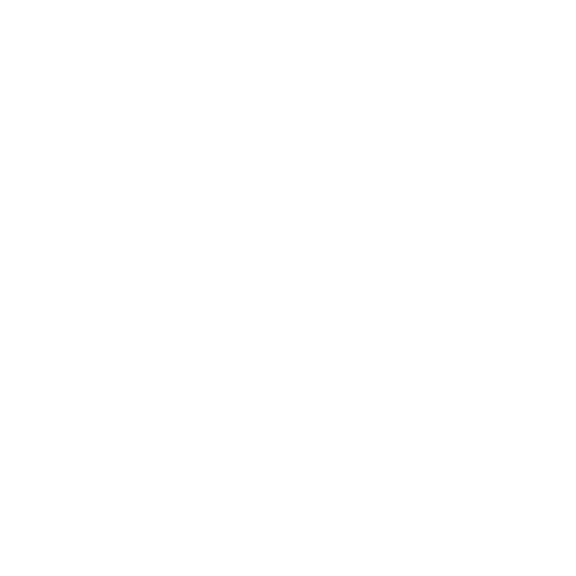

<IPython.core.display.Javascript object>


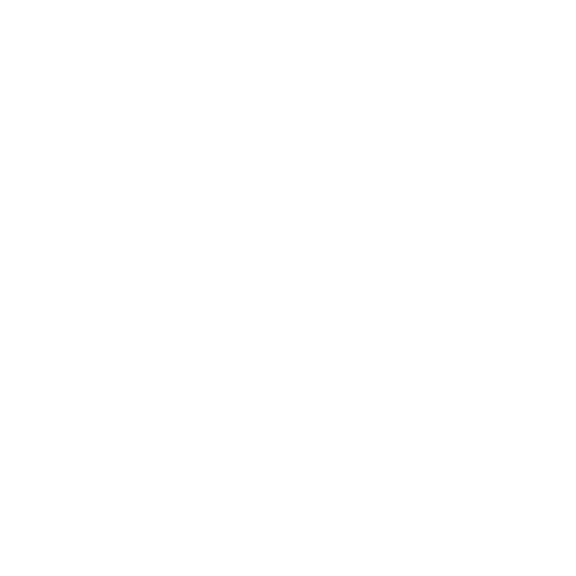

In [133]:
%matplotlib notebook
xdata = np.linspace(0,100, num=100)
ydata = np.linspace(0,100, num=100)

fig, ax = plt.subplots(figsize=(4,4))
ax.set_ylim(0,100)
ax.set_xlim(0,100)
# line, = ax.plot(xdata, ydata)
event_list = []
key_list = []

def toggle_selector(event):
    print(' Key pressed.')
    if event.key in ['Q', 'q'] and toggle_selector.RS.active:
        print(' RectangleSelector deactivated.')
        toggle_selector.RS.set_active(False)
    if event.key in ['R', 'r']:
        print(' RectangleSelector reset.')
        ax.cla()
        ax.set_ylim(0,100)
        ax.set_xlim(0,100)
    if event.key in rect_colors.keys():
        ax.set_title('Class:'+layer_names[event.key])
        print('Class', event.key)
        key_list.append(event.key)
        

def line_select_callback(eclick, erelease):
    x1, y1 = eclick.xdata, eclick.ydata
    x2, y2 = erelease.xdata, erelease.ydata
    try:
        color = rect_colors[key_list[-1]]
    except:
        color = rect_colors['1']
    rect = plt.Rectangle((min(x1,x2),min(y1,y2)), np.abs(x1-x2), np.abs(y1-y2), color=color)
    event_list.append((key_list[-1], int(min(x1,x2)),int(min(y1,y2)), int(np.abs(x1-x2)), int(np.abs(y1-y2))))
    ax.add_patch(rect)


rs = RectangleSelector(ax, line_select_callback,
                       drawtype='box', useblit=True, button=[1], 
                       minspanx=5, minspany=5, spancoords='pixels', 
                       interactive=True)
plt.connect('key_press_event', toggle_selector)
plt.show()

In [16]:
# %matplotlib inline
test_image = np.zeros((1,100,100,NUM_BYTES_FOR_MASK), dtype=np.uint8)
for key, x, y, dx, dy in event_list:
    test_image[0, 100-y-dy:100-y, x:x+dx,layers[key]] = 1

img_mask = test_image[0]

INFO:tensorflow:Restoring parameters from /gpfs/scratch/asamanta/models/vae_1024_256_64_sigmoid_adam/model.ckpt
float32
38.1182
Original Images vs Reconstructed Images


<IPython.core.display.Javascript object>


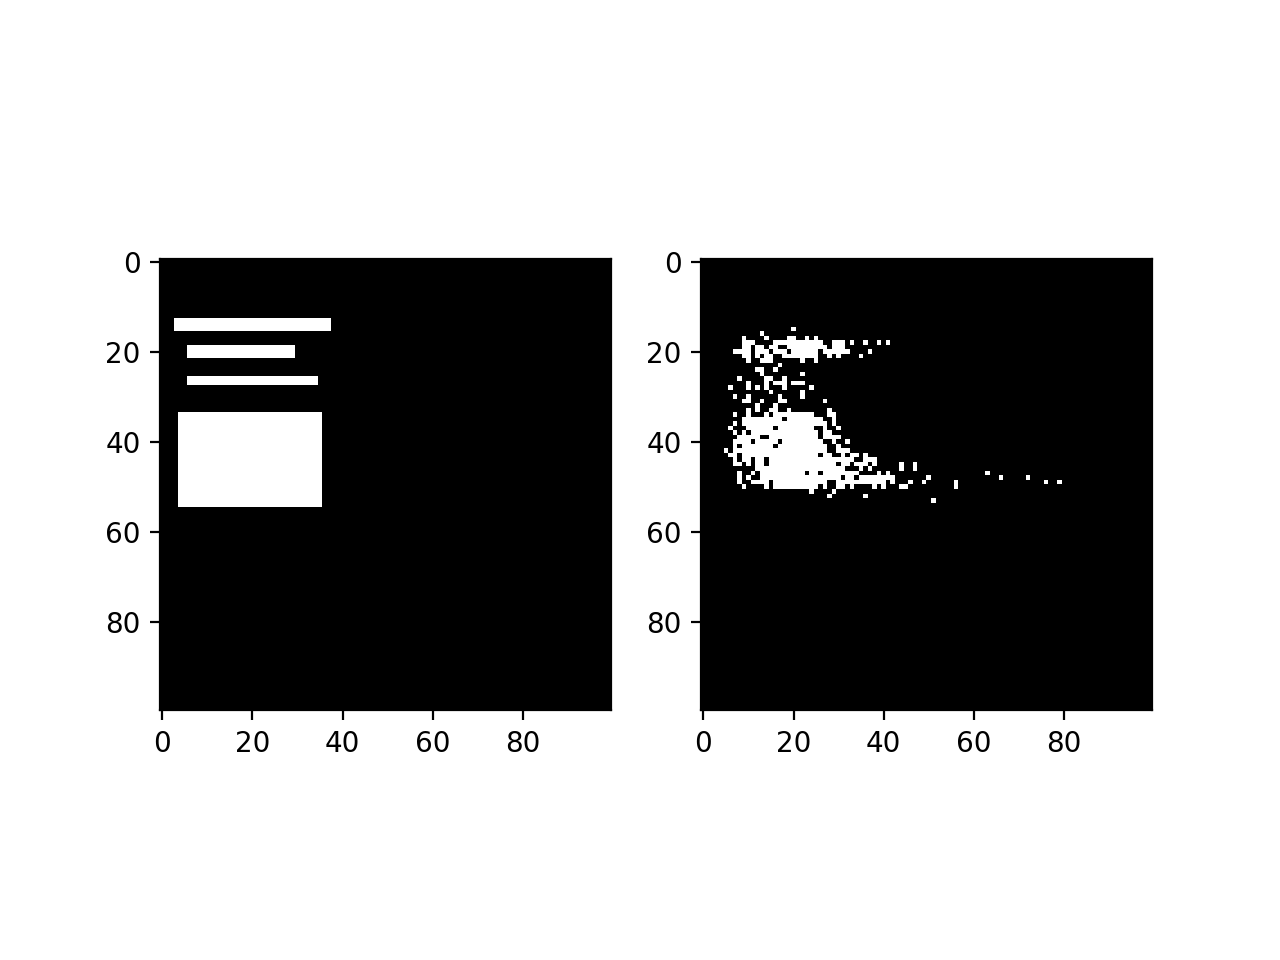

<IPython.core.display.Javascript object>


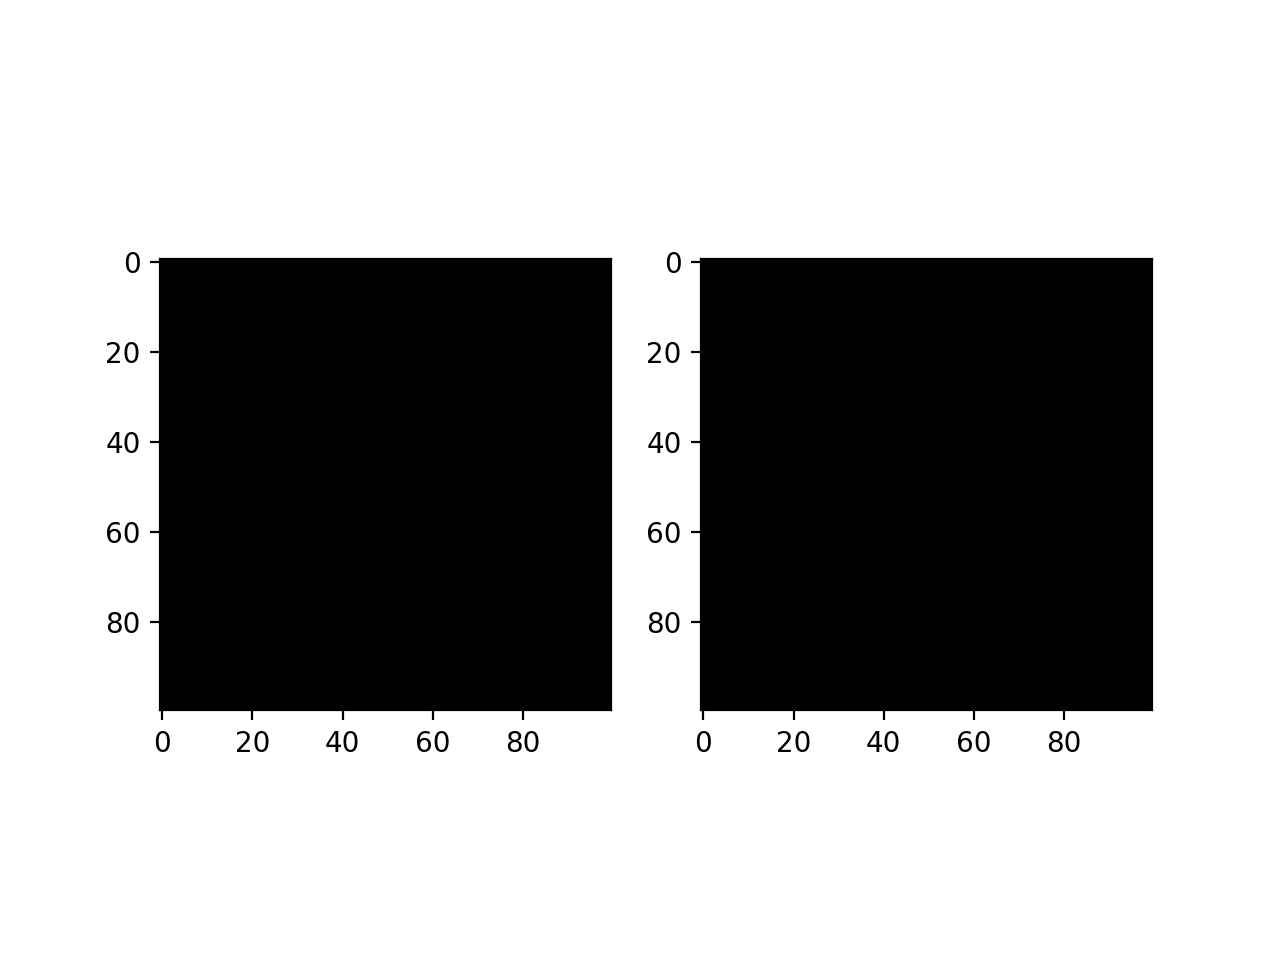

<IPython.core.display.Javascript object>


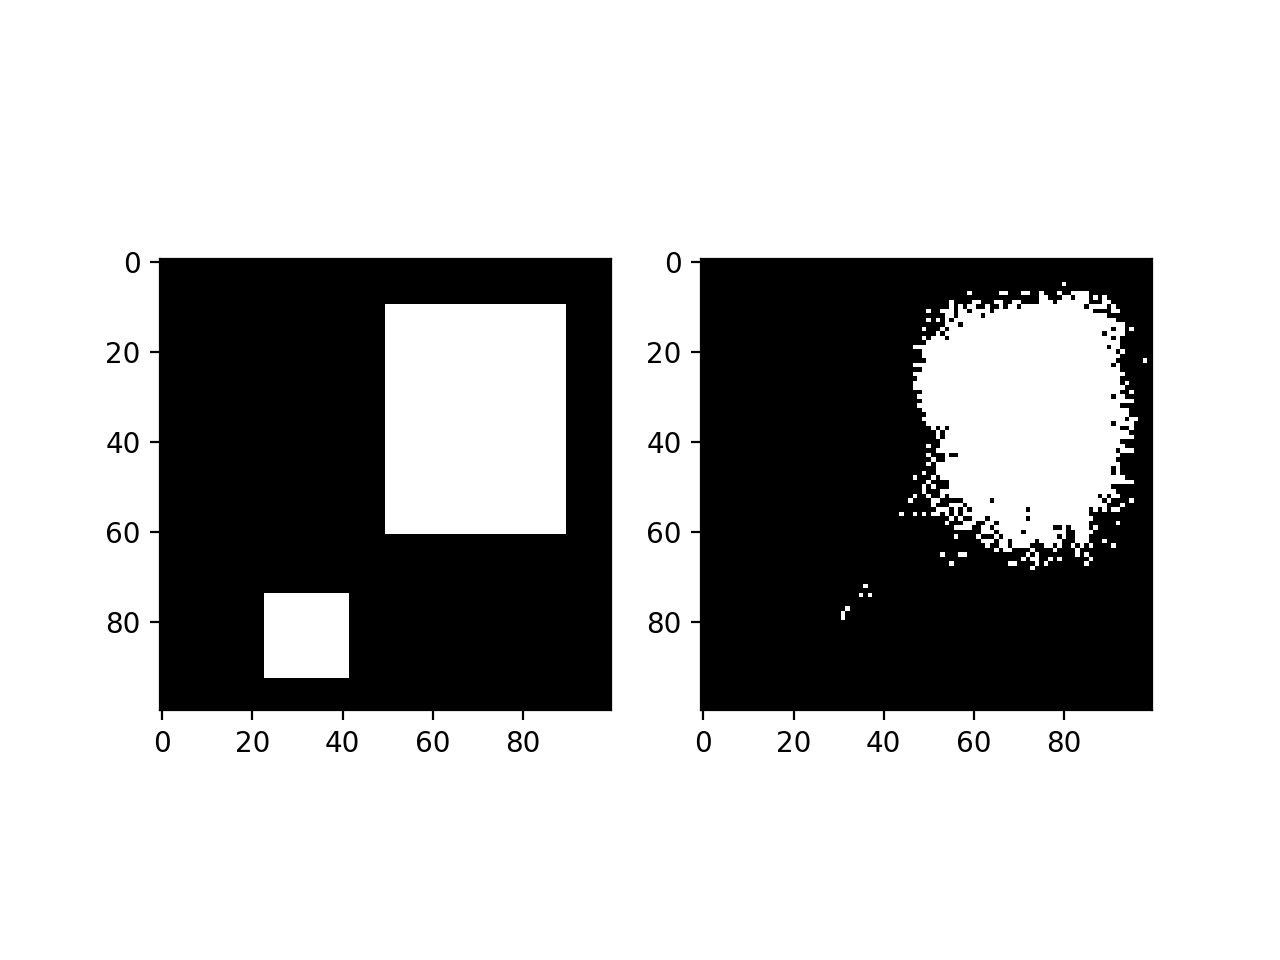

<IPython.core.display.Javascript object>


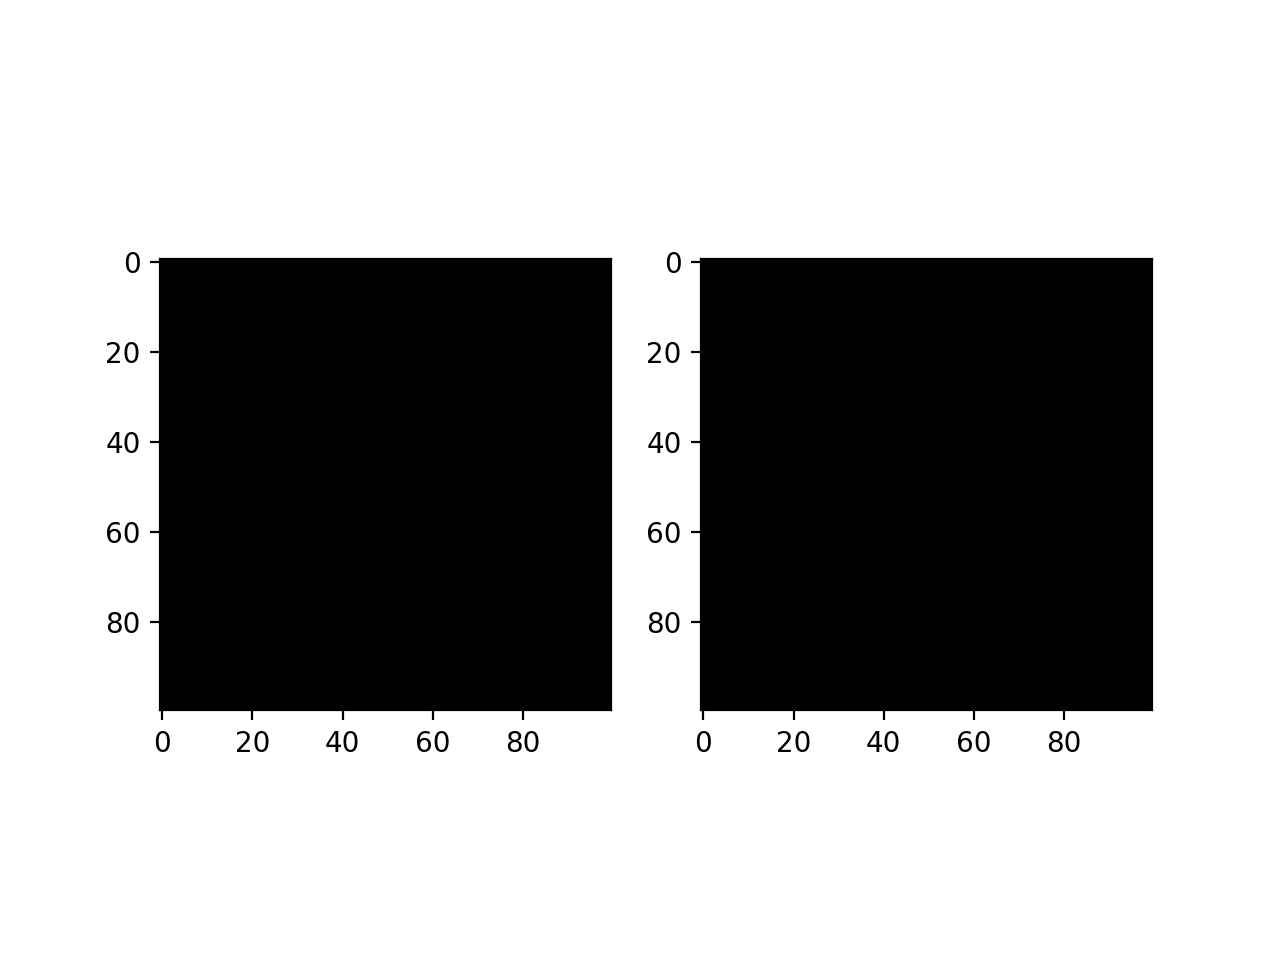

<IPython.core.display.Javascript object>


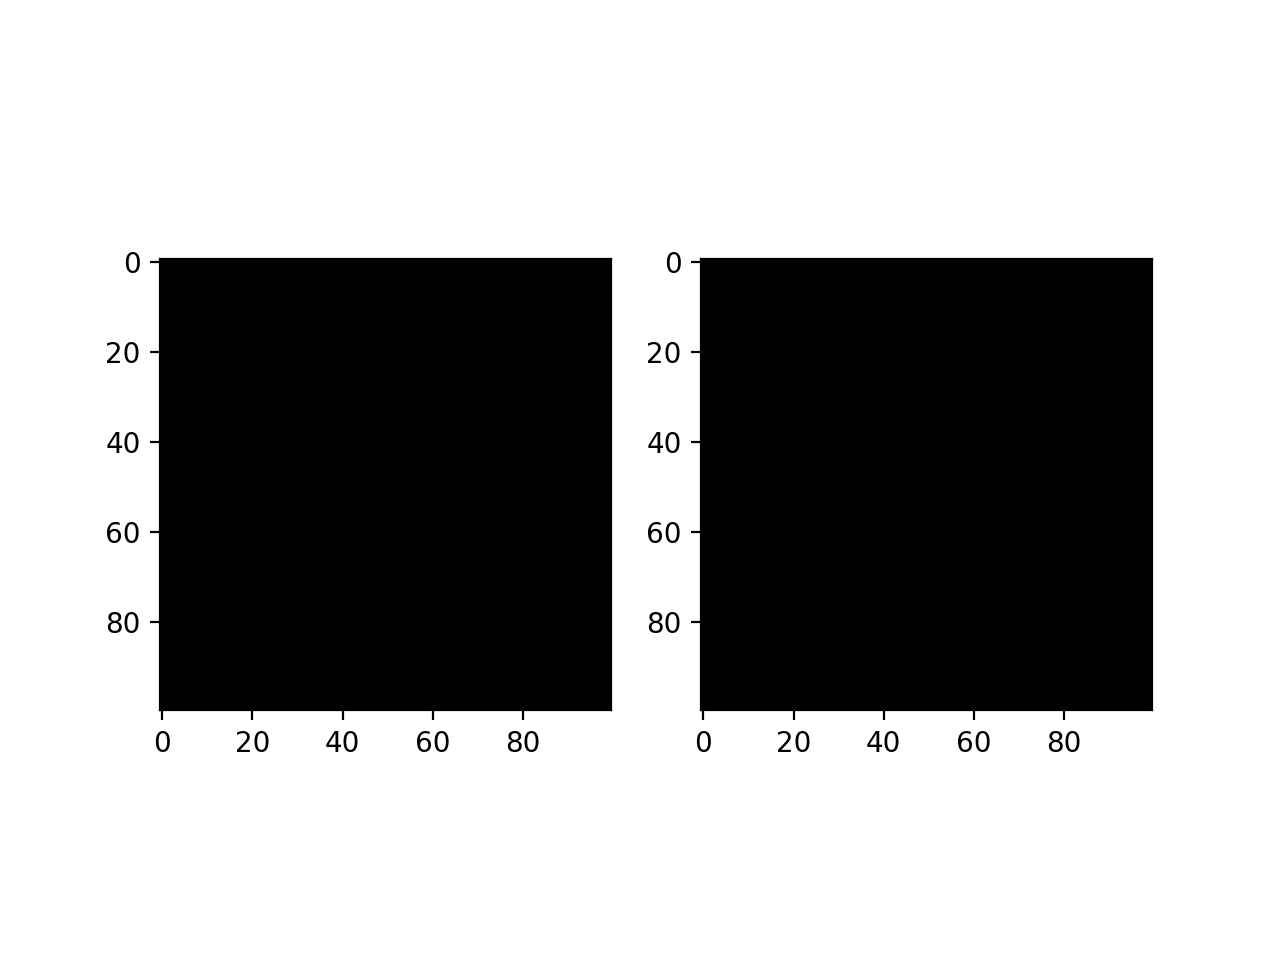

<IPython.core.display.Javascript object>


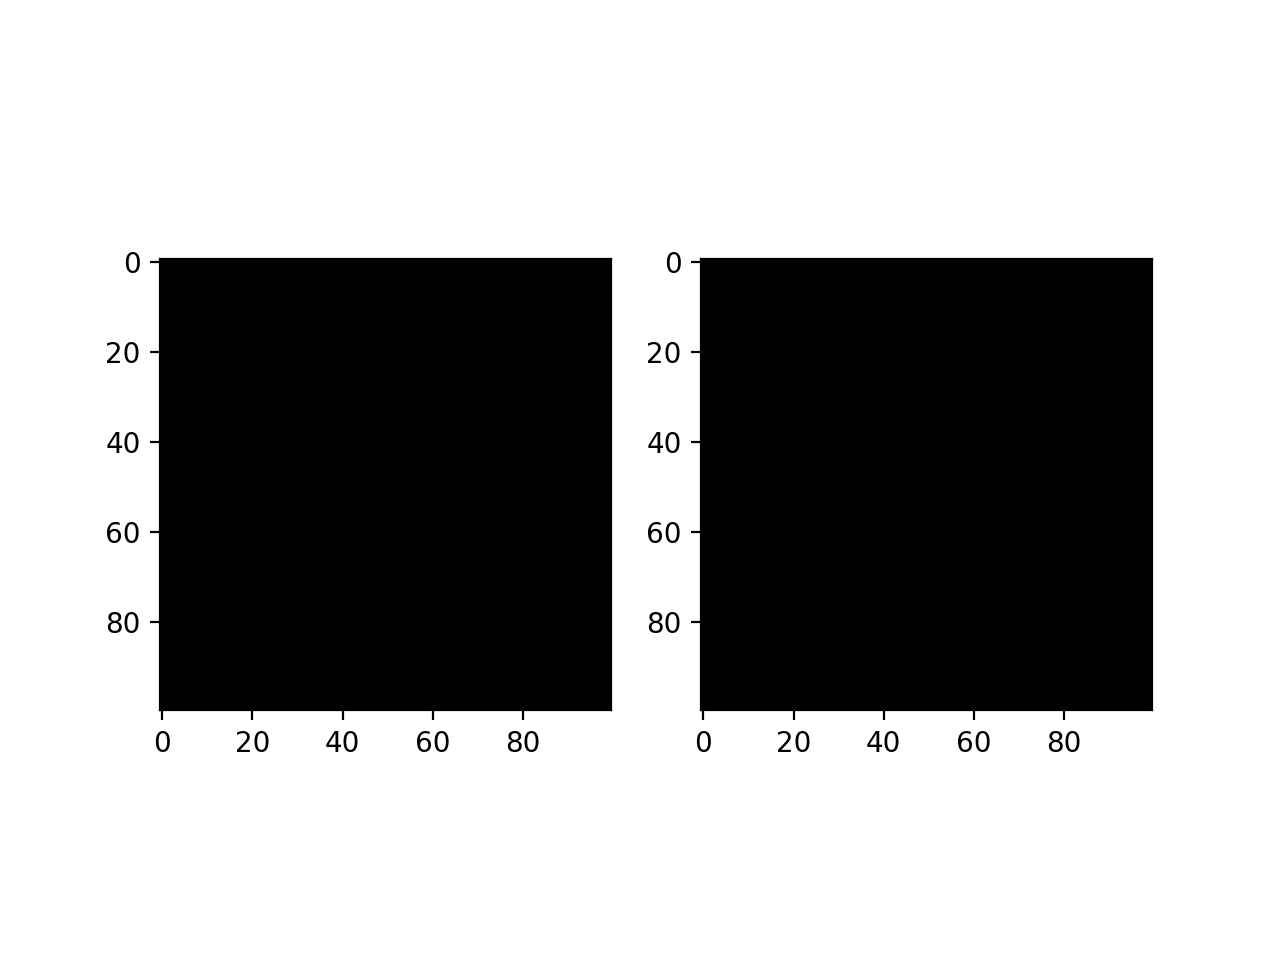

In [22]:
MODEL_PATH = '/gpfs/scratch/asamanta/models/vae_1024_256_64_sigmoid_adam/'
tf.reset_default_graph()
with tf.Session() as sess:
  # Initialize v1 since the saver will not.
#   v1.initializer.run()
    saver = tf.train.import_meta_graph(MODEL_PATH+'model.ckpt.meta')
    saver.restore(sess, tf.train.latest_checkpoint(MODEL_PATH))
    dim_ = 100

    # Image test set
    batch_x = test_image
    batch_x = batch_x.reshape(batch_x.shape[0], -1).astype(np.float32)
    print(batch_x.dtype)
    # Encode and decode the digit image
    output = tf.get_default_graph().get_tensor_by_name("decoder:0")
    ip_img= tf.get_default_graph().get_tensor_by_name("input:0")
    g = sess.run(output, feed_dict={ip_img: batch_x})

    canvas_orig = np.round(batch_x).reshape([dim_, dim_, NUM_BYTES_FOR_MASK])
    canvas_recon = np.round(g).reshape([dim_, dim_, NUM_BYTES_FOR_MASK])
    print(np.linalg.norm(canvas_orig - canvas_recon))

    print("Original Images vs Reconstructed Images")  
    for i in range(NUM_BYTES_FOR_MASK):
        f, axarr = plt.subplots(1,2)
        axarr[0].imshow(canvas_orig[:,:,i], origin="upper", cmap="gray")
        axarr[1].imshow(canvas_recon[:,:,i], origin="upper", cmap="gray")
    plt.show()